In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import plotly.graph_objects as go
from dotenv import load_dotenv
import os

In [12]:
load_dotenv()
engine = create_engine(os.getenv("DATABASE_URL"))

In [15]:
def compute_errors(df, metrics):
    """Compute MAE and RMSE errors for each metric."""
    summary = {}
    for metric in metrics:
        actual_col = f"{metric}_actual"
        forecast_col = f"{metric}_forecast"
        error_col = f"error_{metric}"

        if actual_col in df.columns and forecast_col in df.columns:
            df[error_col] = df[actual_col] - df[forecast_col]
            summary[metric] = {
                "mae": df[error_col].abs().mean(),
                "rmse": (df[error_col] ** 2).mean() ** 0.5,
            }
    return df, summary

def compute_forecast_error_std(df, metrics, city_filter=None):

    filtered_df = df.copy()
    if city_filter:
        filtered_df = filtered_df[filtered_df['city'] == city_filter]

    results = []
    for metric in metrics:
        actual_col = f"{metric}_actual"
        forecast_col = f"{metric}_forecast"

        if actual_col not in filtered_df.columns or forecast_col not in filtered_df.columns:
            continue

        errors = filtered_df[forecast_col] - filtered_df[actual_col]
        errors = errors.dropna()

        if not errors.empty:
            std_dev = errors.std()
            results.append({
                "city": city_filter or "All",
                "metric": metric,
                "std_dev": round(std_dev, 3),
                "n": len(errors)
            })

    return pd.DataFrame(results)

def plot_metrics_matplotlib(df, metrics, time_col="as_of", city_filter=None):
    """
    Matplotlib chart function for:
    - Actual vs Forecast (if *_actual and *_forecast columns exist)
    - Measured values over time (otherwise)
    """
    filtered_df = df.copy()

    if city_filter:
        filtered_df = filtered_df[filtered_df["city"] == city_filter]

    if filtered_df.empty:
        print(f"No data for city: {city_filter}")
        return

    filtered_df[time_col] = pd.to_datetime(filtered_df[time_col])
    filtered_df = filtered_df.sort_values(time_col)

    for metric in metrics:
        actual_col = f"{metric}_actual"
        forecast_col = f"{metric}_forecast"

        plt.figure(figsize=(10, 5))

        if actual_col in filtered_df.columns and forecast_col in filtered_df.columns:
            df_metric = filtered_df[[time_col, actual_col, forecast_col]].dropna()

            if df_metric.empty:
                print(f"No valid forecast/actual data for {metric}")
                continue

            plt.plot(df_metric[time_col], df_metric[actual_col], marker='o', label=f"Actual {metric}")
            plt.plot(df_metric[time_col], df_metric[forecast_col], marker='x', label=f"Forecast {metric}")
            plt.title(f"{metric.capitalize()} Forecast vs Actual – {city_filter or 'All cities'}")

        elif metric in filtered_df.columns:
            for city in filtered_df["city"].unique():
                city_df = filtered_df[filtered_df["city"] == city]
                plt.plot(city_df[time_col], city_df[metric], marker='o', label=city)
            plt.title(f"{metric.capitalize()} Measured (15-min intervals) – {city_filter or 'All cities'}")

        else:
            print(f"Metric '{metric}' not found.")
            continue

        plt.xlabel("Time")
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()



In [16]:
# Load data
forecast_sql = """
    SELECT wf.*
    FROM reporting_data.weather_forecast wf
    INNER JOIN (
        SELECT city, forecast_for, MAX(prediction_generated_at) AS max_generated
        FROM reporting_data.weather_forecast
        GROUP BY city, forecast_for
    ) latest
    ON wf.city = latest.city
    AND wf.forecast_for = latest.forecast_for
    AND wf.prediction_generated_at = latest.max_generated
    ORDER BY wf.city, wf.forecast_for
"""
forecast_df = pd.read_sql(forecast_sql, engine)
current_df_full = pd.read_sql("SELECT * FROM reporting_data.weather_current", engine)

# Convert timestamps to datetime
forecast_df["forecast_for"] = pd.to_datetime(forecast_df["forecast_for"])
forecast_df["forecast_for_hour"] = forecast_df["forecast_for"].dt.floor("h")

current_df_full["as_of"] = pd.to_datetime(current_df_full["as_of"])

# Filter actual observations to full hours only
current_df = current_df_full[current_df_full["as_of"].dt.minute == 0].copy()
current_df["as_of_hour"] = current_df["as_of"]

# Merge actual and forecast data on city and hour
df = pd.merge(
    current_df,
    forecast_df,
    left_on=["city", "as_of_hour"],
    right_on=["city", "forecast_for_hour"],
    suffixes=("_actual", "_forecast")
)

# Define metrics to compare
metrics = ['temp_c', 'wind_kph', 'humidity', 'precip_mm', 'pressure_mb', 'cloud', 'feelslike_c']

# Compute deltas between forecast and actual values
for metric in metrics:
    df[f"delta_{metric}"] = df[f"{metric}_forecast"] - df[f"{metric}_actual"]


In [17]:
# DATA sample
df.head(2)

,id_actual,city,as_of,temp_c_actual,temp_f_actual,is_day_actual,condition_text_actual,condition_icon_actual,condition_code_actual,wind_mph_actual,...,prediction_generated_at,fetched_at_forecast,forecast_for_hour,delta_temp_c,delta_wind_kph,delta_humidity,delta_precip_mm,delta_pressure_mb,delta_cloud,delta_feelslike_c
0,17,Prague,2025-07-12 16:00:00,18.1,64.6,1,Light drizzle,//cdn.weatherapi.com/weather/64x64/day/266.png,1153,3.4,...,2025-07-12 20:15:03.188438,2025-07-12 20:15:03.186395,2025-07-12 16:00:00,-3.6,2.5,14,0.48,1.0,77,-3.8
1,18,London,2025-07-12 16:00:00,30.4,86.7,1,Sunny,//cdn.weatherapi.com/weather/64x64/day/113.png,1000,10.5,...,2025-07-12 20:15:03.624644,2025-07-12 20:15:03.622063,2025-07-12 16:00:00,-1.5,1.5,-3,0.00,-1.0,8,-1.5


####  Forecast Error Summary

This summary evaluates the accuracy of weather forecasts compared to actual measured data. Two key error metrics are used:

- **MAE (Mean Absolute Error):** Represents the average size of prediction errors, regardless of direction.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily and emphasizes outliers.

Lower values indicate more accurate predictions. In general, temperature, wind speed, and pressure forecasts are reasonably accurate. Larger discrepancies are seen in cloud cover and humidity, which are more variable and harder to predict precisely.

In [18]:

metrics_to_compare = ['temp_c', 'wind_kph', 'humidity', 'precip_mm',
                      'pressure_mb', 'cloud', 'feelslike_c']
comparison_df, summary = compute_errors(df, metrics_to_compare)
pd.DataFrame(summary).T



,mae,rmse
temp_c,2.028571,2.315476
wind_kph,0.978571,1.902067
humidity,7.928571,11.106626
precip_mm,0.092143,0.181443
pressure_mb,0.428571,0.654654
cloud,12.928571,22.666842
feelslike_c,2.207143,2.419416


In [19]:

compute_forecast_error_std(df, metrics_to_compare, city_filter="Prague")

,city,metric,std_dev,n
0,Prague,temp_c,1.048,8
1,Prague,wind_kph,2.503,8
2,Prague,humidity,12.165,8
3,Prague,precip_mm,0.199,8
4,Prague,pressure_mb,0.518,8
5,Prague,cloud,31.437,8
6,Prague,feelslike_c,0.966,8


##### Conclusion from Error Tables

The forecast accuracy for Prague varies significantly across weather metrics:

- **Most reliable predictions** were for:
  - `temp_c` and `feelslike_c`: Low MAE (~2 °C), RMSE below 2.5 °C, and std_dev < 1.1 → stable and precise.
  - `precip_mm`: Very low error and deviation → excellent rain prediction consistency.
  - `pressure_mb`: Low overall error and deviation → good atmospheric pressure forecasting.

- **Least reliable predictions** were:
  - `cloud` and `humidity`: High RMSE (up to 22) and std_dev (> 12–31) → forecasts fluctuated heavily and lacked accuracy.

These results suggest that while the API provides solid short-term forecasts for core metrics (temperature, rain, pressure), **cloud coverage and humidity remain more volatile and less predictable** – which aligns with known weather modeling challenges.


####  Measured values 


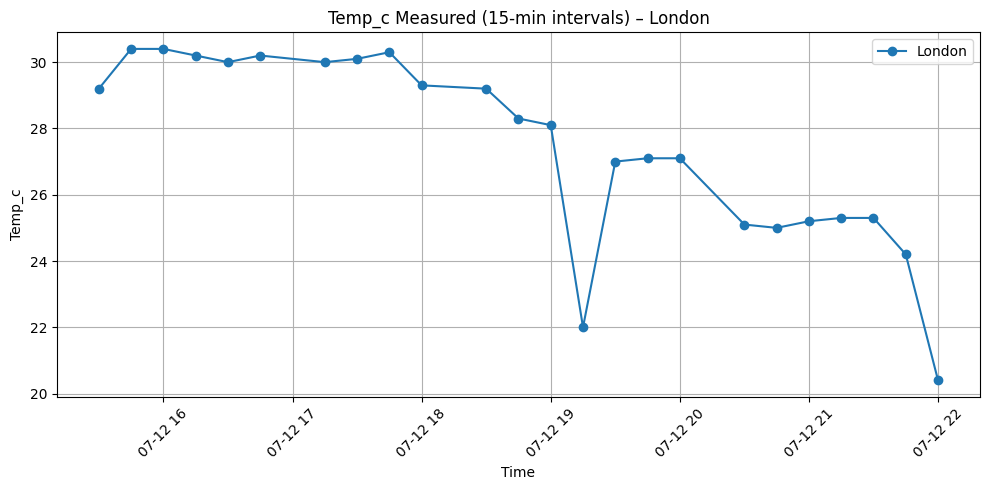

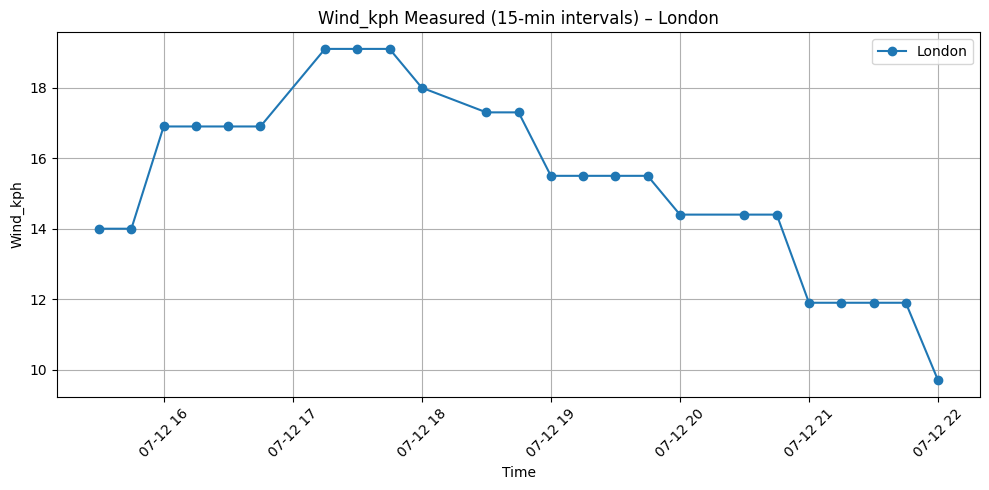

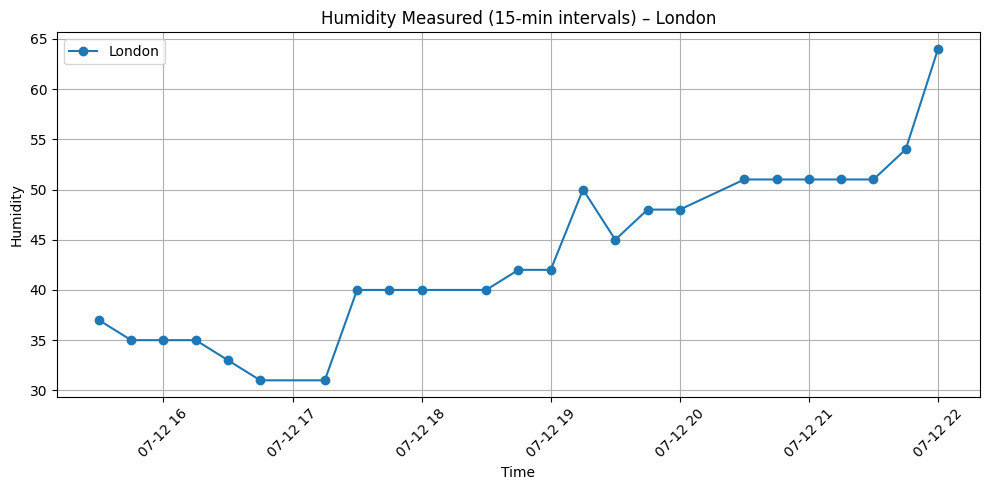

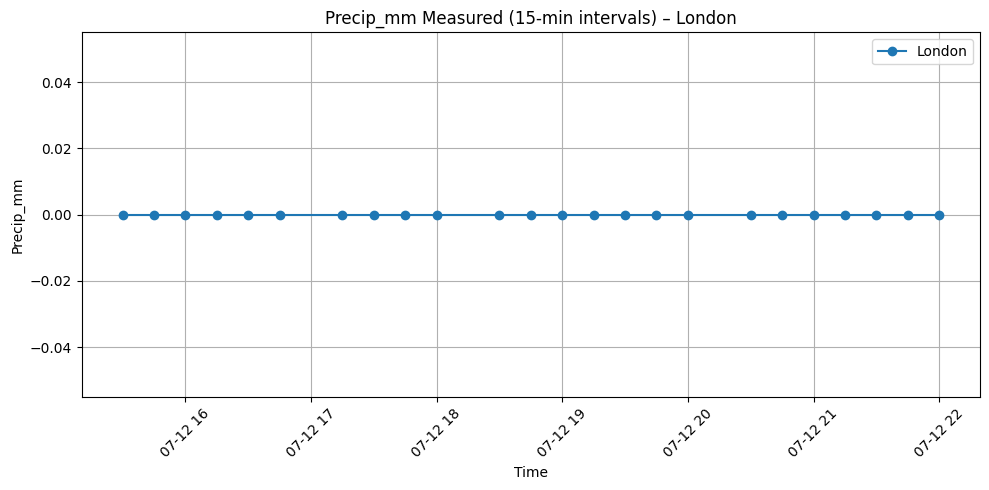

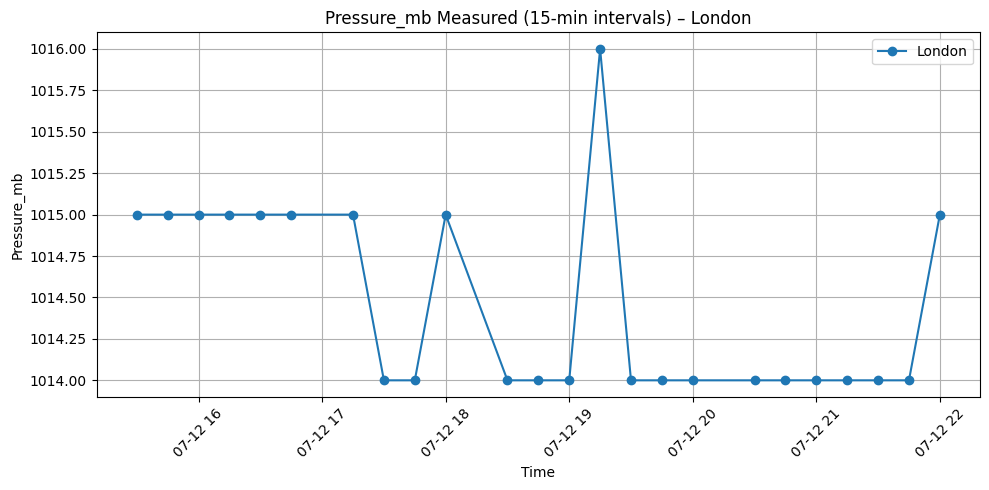

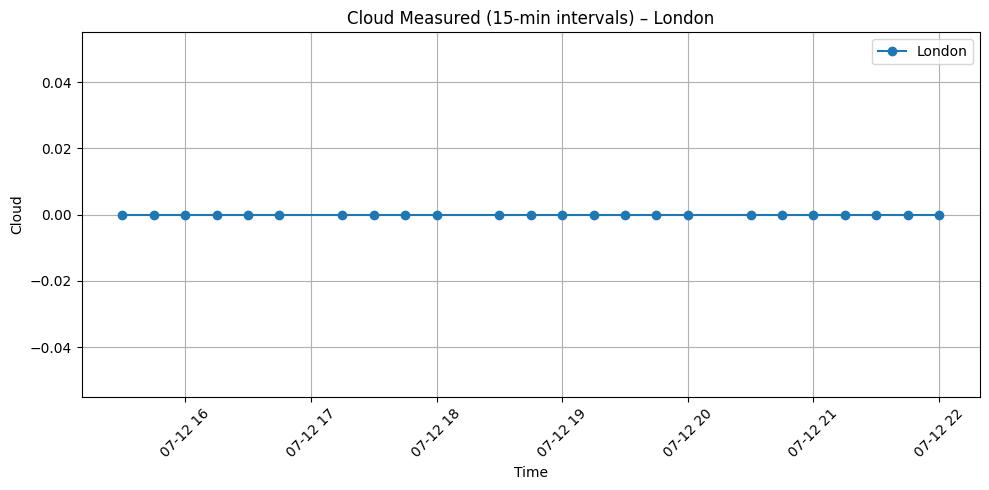

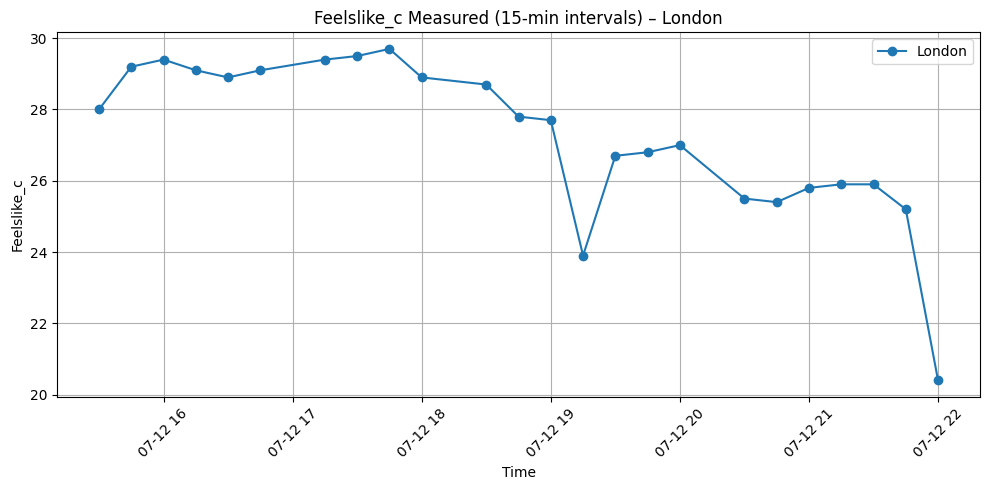

In [20]:
plot_metrics_matplotlib(current_df_full, metrics=metrics_to_compare, time_col="as_of", city_filter="London")

#### Comparison of measured value vs predicted value

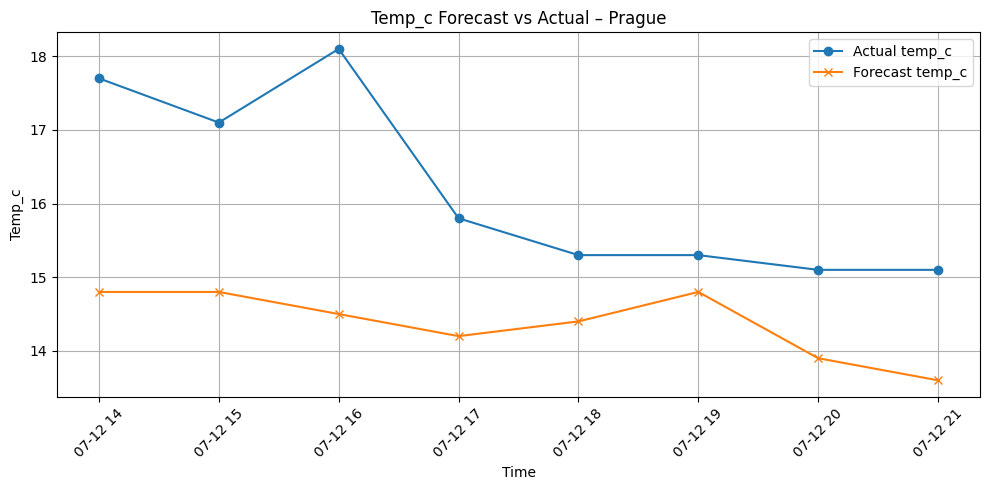

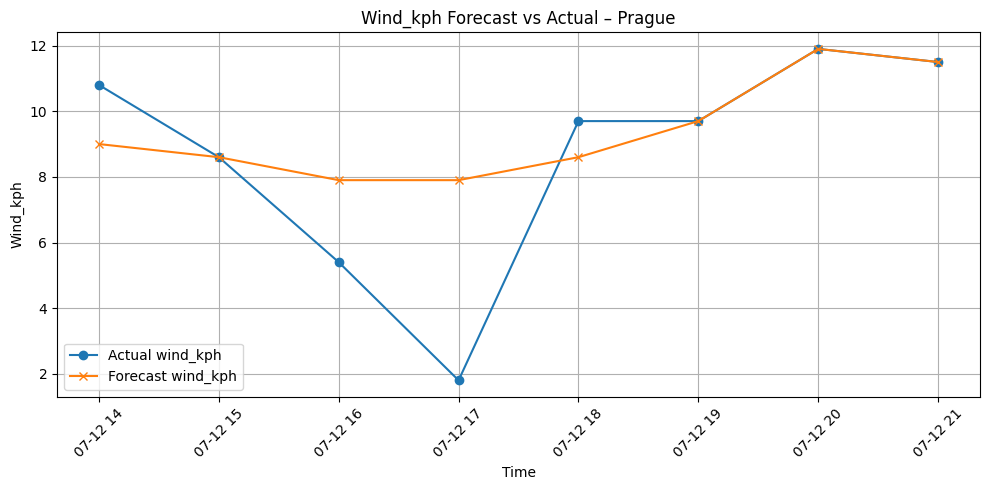

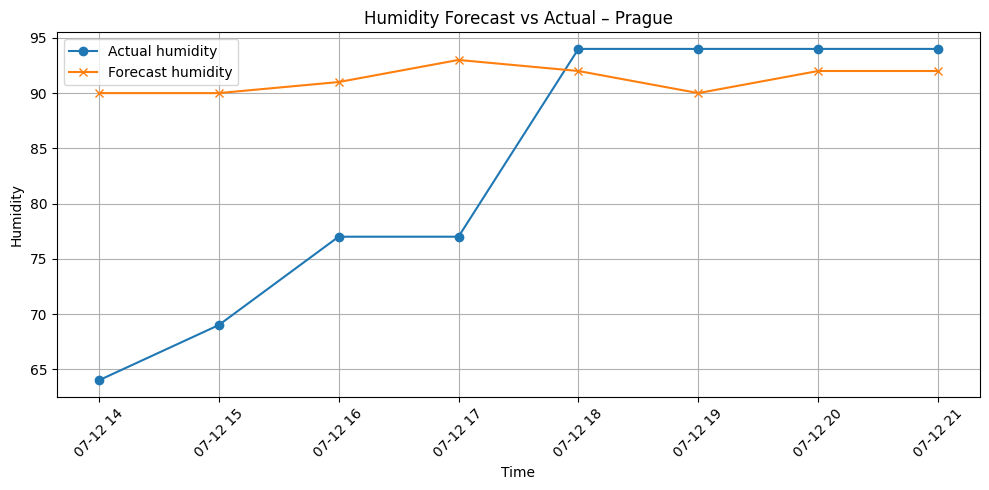

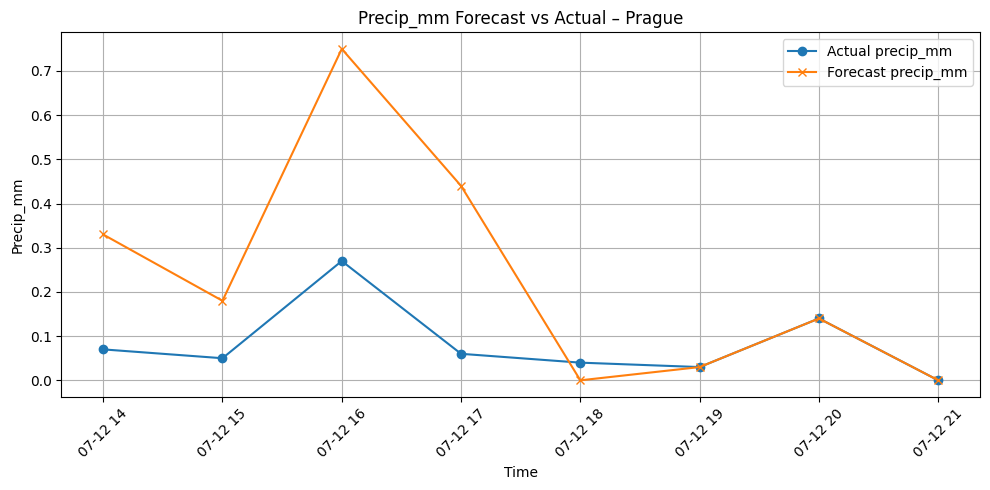

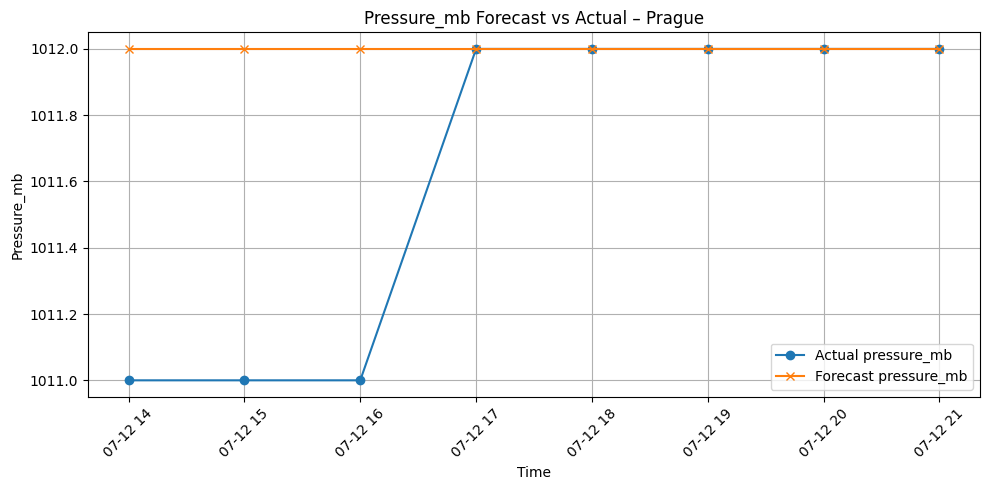

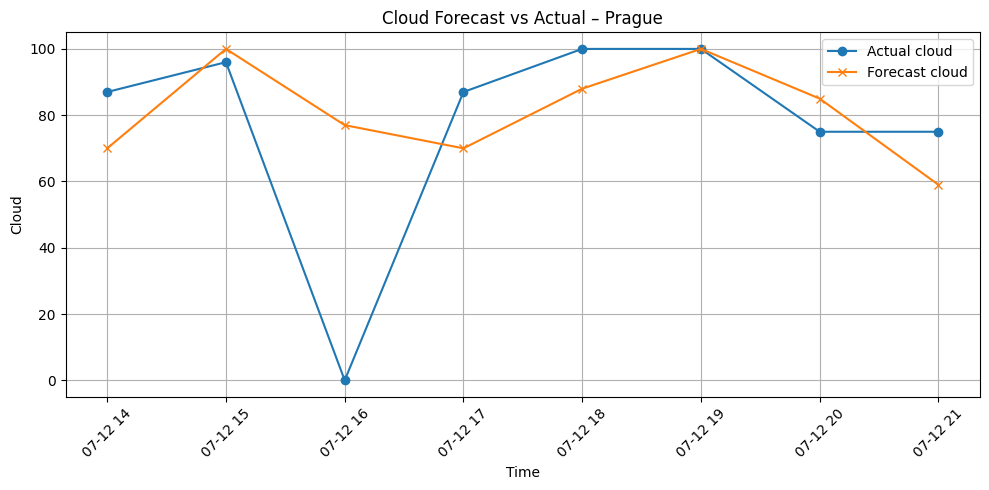

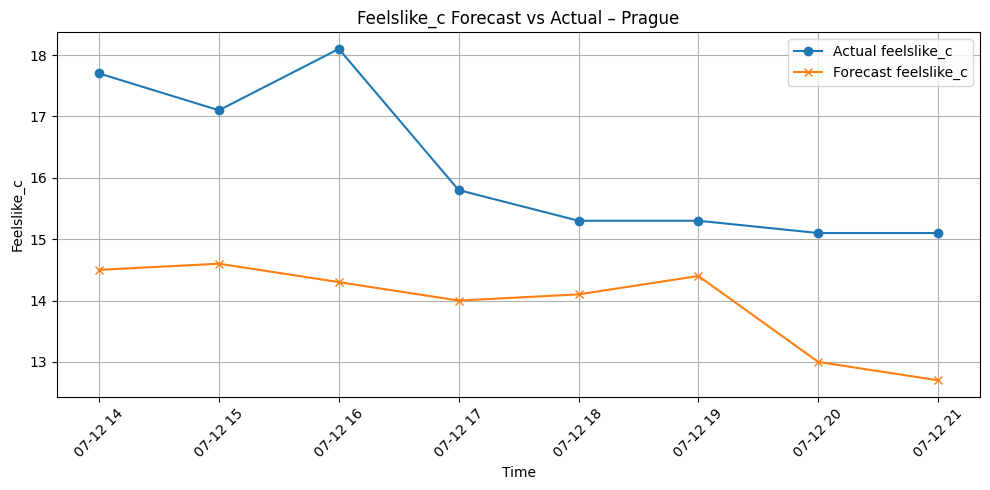

In [21]:
plot_metrics_matplotlib(df, metrics=metrics_to_compare, time_col="as_of", city_filter="Prague")
